# Skin cancer - malign vs belign

In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
import numpy as np

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [3]:
path =  '/home/ubuntu/datasets/'
dataset_path = path + 'ISIC/ISIC-2017_Training_Data/'
sample_dataset_path = path + 'ISIC-sample/ISIC-2017_Training_Data/'

from numpy import genfromtxt
metadata = genfromtxt(path + 'ISIC/ISIC-2017_Training_Part3_GroundTruth.csv', 
                     skip_header= True,
                     delimiter=',',
                     dtype=[('image_id','S12'),('melanoma','i1'),('seborrheic_keratosis','i1')])

## Creating a sample dataset

In [6]:
np.random.seed(42)
np.random.shuffle(metadata)
sample_metadata = metadata[:]

In [7]:
import shutil
import os

def copy_images(line, set_folder):
    directory = sample_dataset_path + set_folder
    if not os.path.exists(directory): os.makedirs(directory)
    if not os.path.exists(directory + 'benign/'): os.makedirs(directory + 'benign/')
    if not os.path.exists(directory + 'malign/'): os.makedirs(directory + 'malign/')
        
    for image_id, melanoma, seborrheic_keratosis in line : 
        image_class = 'benign/' if melanoma == 0 else 'malign/'
        image_filename = image_id + '.jpg'
        pixel_filename = image_id + '_superpixels.png'

        shutil.copy(dataset_path + image_filename, directory + image_class + image_filename)

        # only working with the original picture for now
        # shutil.copy(dataset_path + pixel_filename, directory + image_class + pixel_filename)    

half_idx = len(sample_metadata)/2
three_quarters_idx = 3*len(sample_metadata)/4

copy_images(sample_metadata[:half_idx], 'train/')
copy_images(sample_metadata[half_idx:three_quarters_idx], 'valid/')
copy_images(sample_metadata[three_quarters_idx:], 'test/')

In [8]:
len(sample_metadata[:half_idx])

1000

Let's set sample path and metada as default.

In [9]:
dataset_path = sample_dataset_path
metadata = sample_metadata

In [10]:
batch_size = 4

## Loading data

In [11]:
def image_generator(dirname, class_mode='categorical') :
    gen = image.ImageDataGenerator()
    return gen.flow_from_directory(dirname, 
                                   target_size=(224, 224), 
                                   shuffle=False, 
                                   batch_size=1,
                                   class_mode=class_mode)

In [12]:
val_batches = image_generator(dataset_path + 'valid')
train_batches = image_generator(dataset_path + 'train')

Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
def get_data(path) :
    batches = image_generator(path, class_mode= None)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

Keras returns *classes* as a single column, so we convert to one hot encoding

In [14]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [15]:
val_classes = val_batches.classes
trn_classes = train_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [16]:
val_data = get_data(dataset_path + 'valid')
trn_data = get_data(dataset_path + 'train')
val_data.shape

Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


(500, 3, 224, 224)

In [ ]:
trn_features = vgg.model.predict(trn_data, batch_size=batch_size)
val_features = vgg.model.predict(val_data, batch_size=batch_size)

In [17]:
gen=image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

## Creating the model

In [26]:
from vgg16 import Vgg16
vgg = Vgg16()

vgg.model.pop()
for layer in vgg.model.layers: layer.trainable=False

vgg.model.add(Dense(2, activation='softmax'))
opt = RMSprop(lr=0.001)
vgg.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
vgg.model.fit_generator(trn_batches, samples_per_epoch=trn_batches.N, nb_epoch=5, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/5
1000/1000 [==============================] - 39s - loss: 1.1520 - acc: 0.7140 - val_loss: 0.5479 - val_acc: 0.7620
Epoch 2/5
1000/1000 [==============================] - 39s - loss: 1.0103 - acc: 0.7240 - val_loss: 0.6536 - val_acc: 0.7040
Epoch 3/5
1000/1000 [==============================] - 40s - loss: 0.9198 - acc: 0.7840 - val_loss: 0.5973 - val_acc: 0.7880
Epoch 4/5
1000/1000 [==============================] - 40s - loss: 0.9190 - acc: 0.7630 - val_loss: 0.5943 - val_acc: 0.7800
Epoch 5/5
1000/1000 [==============================] - 40s - loss: 0.9809 - acc: 0.7820 - val_loss: 0.8807 - val_acc: 0.6660


## Plotting results

In [32]:
from utils import plot_confusion_matrix

preds = vgg.model.predict_classes(val_data, batch_size=batch_size)

500/500 [==============================] - 13s    


Found 500 images belonging to 2 classes.
[[324  86]
 [ 47  43]]


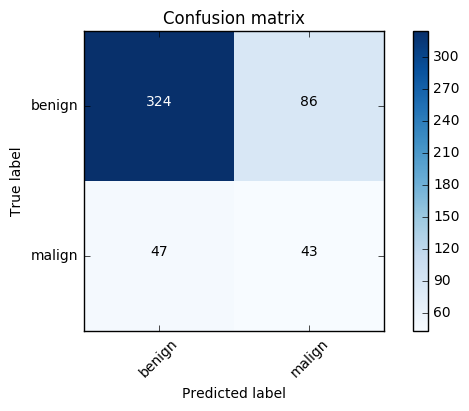

In [33]:
validation_batches = image_generator(dataset_path+'valid/')

cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, validation_batches.class_indices)

# Viewing model prediction samples

In [34]:
probs = vgg.model.predict_proba(val_data, batch_size=batch_size)[:,0]


500/500 [==============================] - 13s    


In [35]:
preds[:8]

array([1, 0, 0, 0, 0, 1, 0, 0])

In [36]:
probs[:8]

array([ 0.0456,  0.9969,  0.8929,  0.9978,  0.9979,  0.2442,  0.9996,  0.9283], dtype=float32)

In [44]:
valid_image_generator_batches = image_generator(dataset_path + 'valid')

Found 500 images belonging to 2 classes.


In [47]:
def plots_idx(idx, titles=None):
    plots([image.load_img(dataset_path + 'valid/' + valid_image_generator_batches.filenames[i]) for i in idx], titles=titles)

# A few correct  labels at random


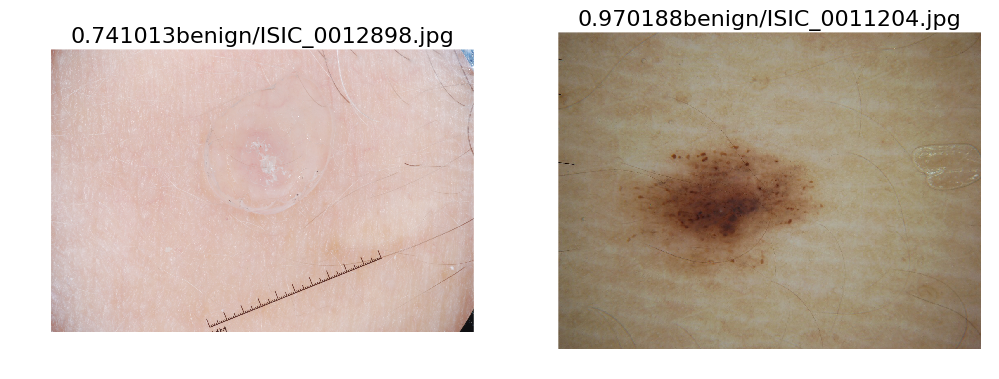

In [76]:
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:2]

titles = []
for i in idx:
    titles.append(str(probs[i]) + valid_image_generator_batches.filenames[i])
plots_idx(idx, titles)

#  The images we most confident were benign, and are actually benign


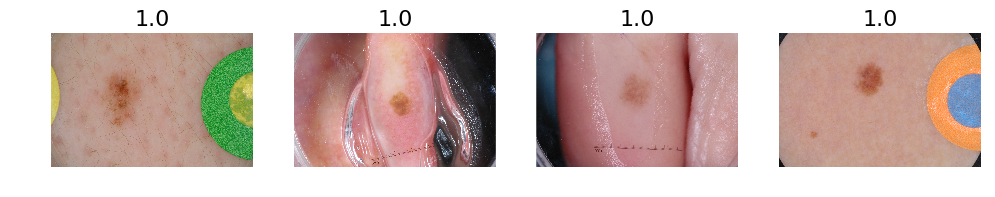

In [57]:
correct_benign = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_benign = np.argsort(probs[correct_benign])[::-1][:4]
plots_idx(correct_benign[most_correct_benign], probs[correct_benign][most_correct_benign])

In [78]:
np.asarray(valid_image_generator_batches.filenames)[correct_benign][most_correct_benign]

array(['benign/ISIC_0005555.jpg', 'benign/ISIC_0012285.jpg', 'benign/ISIC_0012670.jpg',
       'benign/ISIC_0009564.jpg'], 
      dtype='|S23')

# As above but malign

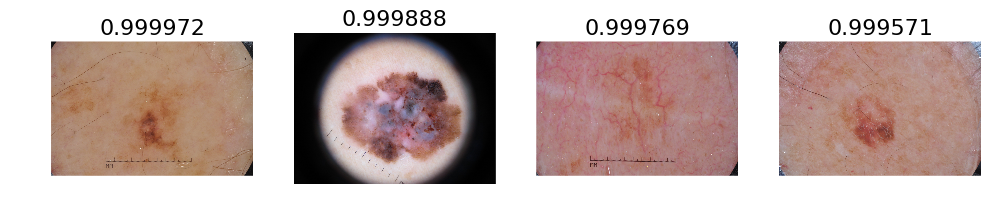

In [77]:
correct_malign = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_malign = np.argsort(probs[correct_malign])[:4]
plots_idx(correct_malign[most_correct_malign], 1-probs[correct_malign][most_correct_malign])

In [79]:
np.asarray(valid_image_generator_batches.filenames)[correct_malign][most_correct_malign]

array(['malign/ISIC_0014108.jpg', 'malign/ISIC_0000281.jpg', 'malign/ISIC_0014331.jpg',
       'malign/ISIC_0014291.jpg'], 
      dtype='|S23')

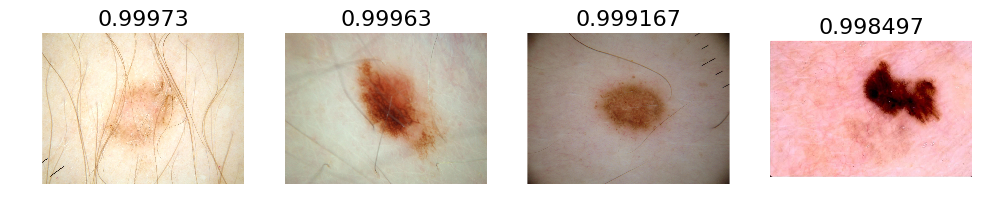

In [80]:
#3. The images we were most confident were benign, but are actually malign
incorrect_malign = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_malign = np.argsort(probs[incorrect_malign])[::-1][:4]
plots_idx(incorrect_malign[most_incorrect_malign], probs[incorrect_malign][most_incorrect_malign])

In [81]:
np.asarray(valid_image_generator_batches.filenames)[incorrect_malign][most_incorrect_malign]

array(['malign/ISIC_0011344.jpg', 'malign/ISIC_0011169.jpg', 'malign/ISIC_0001105.jpg',
       'malign/ISIC_0000165.jpg'], 
      dtype='|S23')

## Trainning multiple layers

In [30]:
layers = vgg.model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

In [31]:
vgg.model.fit_generator(trn_batches, samples_per_epoch=trn_batches.N, nb_epoch=5, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/5
1000/1000 [==============================] - 39s - loss: 0.9408 - acc: 0.7760 - val_loss: 0.6661 - val_acc: 0.8020
Epoch 2/5
1000/1000 [==============================] - 39s - loss: 1.0500 - acc: 0.7620 - val_loss: 0.7818 - val_acc: 0.7180
Epoch 3/5
1000/1000 [==============================] - 40s - loss: 0.9256 - acc: 0.7690 - val_loss: 0.6991 - val_acc: 0.7580
Epoch 4/5
1000/1000 [==============================] - 39s - loss: 0.9988 - acc: 0.7870 - val_loss: 1.0361 - val_acc: 0.6760
Epoch 5/5
1000/1000 [==============================] - 40s - loss: 1.0752 - acc: 0.7780 - val_loss: 0.8014 - val_acc: 0.7340
